# Guide 4: Research Projects with JAX

**Filled notebook:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/guide4/Research_Projects_with_JAX.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/guide4/Research_Projects_with_JAX.ipynb)   
**Author:** Phillip Lippe

This guide summarizes some tips, tricks and practices that are useful when working with JAX for a research project. In my opinion, one key aspect that JAX is missing compared to PyTorch is a framework like [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/stable/) that can massively reduce code overhead while still being flexible enough for supporting almost any model/task. Although there exist such libraries for certain common tasks, like [trax](https://github.com/google/trax) or [scenic](https://github.com/google-research/scenic) (attention-based CV), I have not come across one so far which was sufficiently flexible for my research. Hence, in this guide, we build a simpler version of a PyTorch Lightning trainer, that summarizes all training, logging, etc. behavior that we need for almost any model, and allows training various models with much fewer lines than from scratch. Moreover, we implement some simple examples to showcase possible training structures, and underline its flexibility by performing automatic hyperparameter tuning with [Optuna](https://optuna.readthedocs.io/en/stable/index.html). Since this guide will be about code structures, it is more code-heavy than the other guides and can also be run in Google Colab if preferred.

First, let's import some standard libraries. For this guide, we will use the data loading functionalities of PyTorch, but one could also use the [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/data) dataset API. Additionally, we integrate loggers from PyTorch Lightning since they support a flexible API and have most popular logging application implemented (e.g. [TensorBoard](https://www.tensorflow.org/tensorboard), [Weights and Biases](https://wandb.ai/site)).

In [2]:
# Standard libraries
import os
import sys
from typing import Any, Sequence
import json
import time
from tqdm.auto import tqdm
import numpy as np
from copy import copy
from glob import glob
from collections import defaultdict

# JAX/Flax
# If you run this code on Colab, remember to install flax and optax
# !pip install --quiet --upgrade flax optax
import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn
from flax.training import train_state, checkpoints
import optax

# PyTorch for data loading
import torch
import torch.utils.data as data

# Logging with Tensorboard or Weights and Biases
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

## Trainer module for JAX with Flax

As seen in previous tutorials, [Flax](https://flax.readthedocs.io/en/latest/) gives us already some basic functionalities for training models. One part of it is the `TrainState`, which holds the model parameters and optimizers, and allows updating it. However, there might be more model aspects that we would like to add to the `TrainState`. For instance, if a model uses Batch Normalization as in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html), we need to keep the batch statistics in order to evaluate the models on a test dataset. Furthermore, many models contain stochastic elements such as dropout or sampling in generative models (e.g. [Normalizing Flows](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial11/NF_image_modeling.html)). Thus, we extend the `TrainState` class from Flax to also include the batch statistics as `batch_stats` and a pseudo-random number generation `rng`. Note that if models do not require these elements, they can simply be `None` without breaking our code.

In [3]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    # If a model has no batch statistics, it is None
    batch_stats : Any = None
    # You can further extend the TrainState by any additional part here
    # For example, rng to keep for init, dropout, etc.
    rng : Any = None

Now we already come to the main part of this guide: the Trainer module for JAX/Flax. The shown module here is not meant to be the 'one and only' way of doing it, and is more meant as showcasing one possible option of obtaining a Lightning-like API in JAX. The module can easily be extended by more functionalities, depending on what is needed/preferred by the individual users.

First let's make a list of functionalities that we would want the Trainer module to include:

* **Logging**: For basically all usecases and models, we want to log our hyperparameters, training/validation performance, and model checkpoints. For the second point, we can make use of PyTorch Lightning's logger classes like `TensorBoardLogger` and `WandbLogger`. For the model checkpoints, we use `flax.checkpoints`. In terms of flexibility, the trainer should support arbitrary sets of hyperparameters, since different models may require different hyperparameters. Similarly, it should be easy to add new metrics for logging, like accuracy for classification or intersection over union for segmentation.
    * Implemented in: `init_logger`, `save_model`, `load_model`, `save_metrics`
* **Model state initialization**: In contrast to PyTorch, JAX separates the model itself from the learnable parameters. Creating a set of parameters for a model requires some boiler-template code, like creating a PRNG for the parameter generation and creating an initial `TrainState`. At the same time, we need to allow overwriting the `model.init` code, since different architectures will have different input arguments for the forward pass (e.g. models with dropout require a dropout-PRNG).
    * Implemented in: `init_model`, `run_model_init`, `print_tabulate`
* **Optimizer initialization**: Following with the parameter initialization, we also need to create an optimizer and its eventual parameters (e.g. momentum and adaptive learning rate parameters in Adam). Since most models use a similar set of optimizers (SGD or Adam) and extra functionalities like gradient clipping and learning rate scheduling, we can write a template method that creates an optimizers based on some hyperparameters. However, it should be possible to overwrite this method if very specific optimizer settings/learning rate schedulers are needed. Since some schedulers require information about the overall number of training iterations, we create the optimizer right before starting the training.
    * Implemented in: `init_optimizer`
* **Training loop**: Most models follow a similar training procedure where we train a model for several epoch on the training dataset, and evaluate it in between on the validation dataset. If a model is better than all previous models, we want to save its weight for loading them potentially later. Importantly, however, each model will have a very different training and validation step. Thus, similarly to PyTorch Lightning, we expect that an inheriting Trainer module has to define a training step function and evaluation step function, that can be jitted and used in the training loop. This is implemented in the function `train_model`, `train_epoch`, `eval_model`, `create_functions`, `create_jitted_functions`. Additional aspects to consider include:
   * Whether a model is better than the previous ones or not depends on the task at hand. For example, classification models are usually compared by their accuracy, trying to achieve the maximum value, while regression models aim for the lowest loss. Hence, we need a flexible API to support different ways of comparing models and finding the best one. Implemented in: `is_new_model_better`
   * Within the training loop, we might want to perform additional operations, like logging reconstruction examples of an autoencoder after every few epochs. To do so, PyTorch Lightning provides functions that are called at different stages during training, which we can similarly integrate in our Trainer module. Implemented in: `on_training_start`, `on_training_epoch_end`, `on_validation_epoch_end`
   * Depending on whether we run the model on a cluster with no display or on our local machine, we might want to see progress bars that track the training progress. Hence, the Trainer module should have to switch to enable or disable these progress bars. Implemented in: `tracker`
* **Inference**: After we have finished training, we might want to load a model at a later time and perform inference experiments with it. For example, in [Tutorial 9](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.html), we use a trained autoencoder for an image search engine. To support this, two functionalities are needed: (1) loading a model from disk, including its hyperparameters (i.e. the function `load_from_checkpoint` in PyTorch Lightning), and (2) binding parameters to a model to reduce code overhead. Both parts can be implemented in our Trainer module.
    * Implemented in: `load_from_checkpoint`, `bind_model` 

With these requirements in mind, let's finally implement the module. Note that it is a considerably long code cell since we want to support many different settings. We recommend to take some time to go through the code and understand how all the elements are implemented, and how one can extend it depending on their own needs.

In [4]:
class TrainerModule:

    def __init__(self, 
                 model_class : nn.Module,
                 model_hparams : dict,
                 optimizer_hparams : dict,
                 exmp_input : Any,
                 seed : int = 42,
                 logger_params : dict = None,
                 cluster : bool = False,
                 debug : bool = False,
                 check_val_every_n_epoch : int = 1,
                 **kwargs):
        """
        
        """
        super().__init__()
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_hparams = optimizer_hparams
        self.cluster = cluster
        self.debug = debug
        self.seed = seed
        self.check_val_every_n_epoch = check_val_every_n_epoch
        self.exmp_input = exmp_input
        self.config = {
            'model_class': model_class.__name__,
            'model_hparams': model_hparams,
            'optimizer_hparams': optimizer_hparams,
            'logger_params': logger_params,
            'cluster': self.cluster,
            'debug': self.debug,
            'check_val_every_n_epoch': check_val_every_n_epoch,
            'seed': self.seed
        }
        self.config.update(kwargs)
        self.has_batch_norm = False
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        self.print_tabulate(exmp_input)
        # Init trainer parts
        self.init_logger(logger_params)
        self.create_jitted_functions()
        self.init_model(exmp_input)

    def init_logger(self, logger_params):
        if logger_params is None:
            logger_params = dict()
        
        log_dir = logger_params.get('log_dir', None)
        if not log_dir:
            base_log_dir = logger_params.get('base_log_dir', 'checkpoints/')
            # Prepare logging
            log_dir = os.path.join(base_log_dir, self.config["model_class"])
            if 'logger_name' in logger_params:
                log_dir = os.path.join(log_dir, logger_params['logger_name'])
            version = None
        else:
            version = ''
        
        logger_type = logger_params.get('logger_type', 'TensorBoard').lower()
        if logger_type == 'tensorboard':
            self.logger = TensorBoardLogger(save_dir=log_dir, 
                                            version=version,
                                            name='')
        elif logger_type == 'wandb':
            self.logger = WandbLogger(name=logger_params.get('project_name', None),
                                      save_dir=log_dir, 
                                      version=version,
                                      config=self.config)
        else:
            assert False, f'Unknown logger type \"{logger_type}\"'
        log_dir = self.logger.log_dir
        if not os.path.isfile(os.path.join(log_dir, 'hparams.json')):
            os.makedirs(os.path.join(log_dir, 'metrics/'), exist_ok=True)
            with open(os.path.join(log_dir, 'hparams.json'), 'w') as f:
                json.dump(self.config, f, indent=4)
        self.log_dir = log_dir

    def init_model(self, exmp_input):
        # Initialize model
        model_rng = random.PRNGKey(self.seed)
        model_rng, init_rng = random.split(model_rng)
        exmp_input = [exmp_input] if not isinstance(exmp_input, (list, tuple)) else exmp_input
        variables = self.run_model_init(exmp_input, init_rng)
        self.init_params = variables['params']
        self.init_batch_stats = variables.get('batch_stats')  # Returns none if no batch stats exist
        self.state = TrainState(step=0, 
                                apply_fn=self.model.apply,
                                params=variables['params'],
                                batch_stats=variables.get('batch_stats'),
                                rng=model_rng,
                                tx=None,
                                opt_state=None)

    def run_model_init(self, exmp_input, init_rng):
        return self.model.init(init_rng, *exmp_input, train=True)

    def print_tabulate(self, exmp_input):
        print(self.model.tabulate(random.PRNGKey(0), *exmp_input, train=True))

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        hparams = copy(self.optimizer_hparams)

        # Initialize learning rate schedule and optimizer
        optimizer_name = hparams.pop('optimizer', 'adamw')
        if optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        
        lr = hparams.pop('lr', 1e-3)
        warmup = hparams.pop('warmup', 0)
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=lr,
            warmup_steps=warmup,
            decay_steps=int(num_epochs * num_steps_per_epoch),
            end_value=0.01 * lr
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip_by_global_norm(hparams.pop('gradient_clip', 1.0))]
        if opt_class == optax.sgd and 'weight_decay' in hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(hparams.pop('weight_decay', 0.0)))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.state.apply_fn,
                                       params=self.state.params,
                                       batch_stats=self.state.batch_stats,
                                       tx=optimizer,
                                       rng=self.state.rng)
    
    def create_jitted_functions(self):
        train_step, eval_step = self.create_functions()
        if self.debug:  # Skip jitting 
            print('Skipping jitting due to debug=True')
            self.train_step = train_step
            self.eval_step = eval_step
        else:
            self.train_step = jax.jit(train_step)
            self.eval_step = jax.jit(eval_step)

    def create_functions(self):
        def train_step(state, batch):
            metrics = {}
            return state, metrics
        def eval_step(state, batch):
            metrics = {}
            return metrics
        raise NotImplementedError

    def train_model(self, train_loader, val_loader, test_loader=None, num_epochs=500):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        self.on_training_start()
        best_eval_metrics = None
        for epoch_idx in self.tracker(range(1, num_epochs+1), desc='Epochs'):
            train_metrics = self.train_epoch(train_loader)
            self.logger.log_metrics(train_metrics, step=epoch_idx)
            self.on_training_epoch_end(epoch_idx)
            if epoch_idx % self.check_val_every_n_epoch == 0:
                eval_metrics = self.eval_model(val_loader, log_prefix='val/')
                self.on_validation_epoch_end(epoch_idx, eval_metrics, val_loader)
                self.logger.log_metrics(eval_metrics, step=epoch_idx)
                self.save_metrics(f'eval_epoch_{str(epoch_idx).zfill(3)}', eval_metrics)
                if self.is_new_model_better(eval_metrics, best_eval_metrics):
                    best_eval_metrics = eval_metrics
                    best_eval_metrics.update(train_metrics)
                    self.save_model(step=epoch_idx)
                    self.save_metrics('best_eval', eval_metrics)
        if test_loader is not None:
            self.load_model()
            test_metrics = self.eval_model(test_loader, log_prefix='test/')
            self.logger.log_metrics(test_metrics, step=epoch_idx)
            self.save_metrics('test', test_metrics)
            best_eval_metrics.update(test_metrics)
        self.logger.finalize('success')
        return best_eval_metrics

    def train_epoch(self, train_loader):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(float)
        num_train_steps = len(train_loader)
        start_time = time.time()
        for batch in self.tracker(train_loader, desc='Training', leave=False):
            self.state, step_metrics = self.train_step(self.state, batch)
            for key in step_metrics:
                metrics['train/' + key] += step_metrics[key] / num_train_steps
        metrics = {key: metrics[key].item() for key in metrics}
        metrics['epoch_time'] = time.time() - start_time
        return metrics

    def eval_model(self, data_loader, log_prefix=''):
        # Test model on all images of a data loader and return avg loss
        metrics = defaultdict(float)
        num_elements = 0
        for batch in data_loader:
            step_metrics = self.eval_step(self.state, batch)
            batch_size = batch[0].shape[0] if isinstance(batch, (list, tuple)) else batch.shape[0]
            for key in step_metrics:
                metrics[key] += step_metrics[key] * batch_size
            num_elements += batch_size
        metrics = {(log_prefix + key): (metrics[key] / num_elements).item() for key in metrics}
        return metrics

    def is_new_model_better(self, new_metrics, old_metrics):
        if old_metrics is None:
            return True
        for key, is_larger in [('val/val_metric', False), ('val/acc', True), ('val/loss', False)]:
            if key in new_metrics:
                if is_larger:
                    return new_metrics[key] > old_metrics[key]
                else:
                    return new_metrics[key] < old_metrics[key]
        assert False, f'No known metrics to log on: {new_metrics}'

    def tracker(self, iterator, **kwargs):
        if not self.cluster:
            return tqdm(iterator, **kwargs)
        else:
            return iterator

    def save_metrics(self, filename, metrics):
        with open(os.path.join(self.log_dir, f'metrics/{filename}.json'), 'w') as f:
            json.dump(metrics, f, indent=4)

    def on_training_start(self):
        pass

    def on_training_epoch_end(self, epoch_idx):
        pass

    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        pass

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params,
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                    overwrite=True)

    def load_model(self):
        # Load model.
        state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       tx=self.state.tx if self.state.tx else optax.sgd(0.1),   # Default optimizer
                                       rng=self.state.rng
                                      )
            
    def bind_model(self):
        params = {'params': self.state.params}
        if self.state.batch_stats:
            params['batch_stats'] = self.state.batch_stats
        return self.model.bind(params)

    @classmethod
    def load_from_checkpoint(cls, checkpoint, exmp_input):
        hparams_file = os.path.join(checkpoint, 'hparams.json')
        assert os.path.isfile(hparams_file), 'Could not find hparams file'
        with open(hparams_file, 'r') as f:
            hparams = json.load(f)
        hparams.pop('model_class')
        hparams.update(hparams.pop('model_hparams'))
        if not hparams['logger_params']:
            hparams['logger_params'] = dict()
        hparams['logger_params']['log_dir'] = checkpoint
        trainer = cls(exmp_input=exmp_input,
                      **hparams)
        trainer.load_model()
        return trainer

### Utility functions

Besides the Trainer module, we have seen other functionalities re-occurring several times in the tutorials. One of them is `numpy_collate`, which is needed for PyTorch's data loader to purely work with NumPy arrays. Similarly, creating Data Loaders for our datasets often follows the same structure, which we can also summarize in a function called `create_data_loaders`.

In [5]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

def create_data_loaders(*datasets, train=True, batch_size=128, num_workers=4, seed=42):
    loaders = []
    if not isinstance(train, (list, tuple)):
        train = [train for _ in datasets]
    for dataset, is_train in zip(datasets, train):
        loader = data.DataLoader(dataset,
                                 batch_size=batch_size,
                                 shuffle=is_train,
                                 drop_last=is_train,
                                 collate_fn=numpy_collate,
                                 num_workers=num_workers,
                                 persistent_workers=is_train,
                                 generator=torch.Generator().manual_seed(seed))
        loaders.append(loader)
    return loaders

## Example 1: Function regression

Using the `TrainerModule` and our few utility functions, we can now write a full training scenario with logging etc. in a few lines. To showcase this, we first consider a very simple scenario: regressing a sine-wave with a neural network.

### Dataset

The first step is to create a dataset. Since we can use PyTorch's data package, this is straightforward. First, let's import needed plotting libraries for visualization and set the data and checkpoint path, similarly as in any other tutorial.

In [6]:
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

DATASET_PATH = '../data/'
CHECKPOINT_PATH = '../saved_models/guide4/'

The dataset is kept very simple and contains pairs of input-output of a sine function:

In [7]:
def target_function(x):
    return np.sin(x * 3.0)

class RegressionDataset(data.Dataset):
    
    def __init__(self, num_points, seed):
        super().__init__()
        rng = np.random.default_rng(seed)
        self.x = rng.uniform(low=-2.0, high=2.0, size=num_points)
        self.y = target_function(self.x)
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx:idx+1], self.y[idx:idx+1]

We can create our needed data loaders with the utility function `create_data_loaders` and visualize the dataset for debugging:

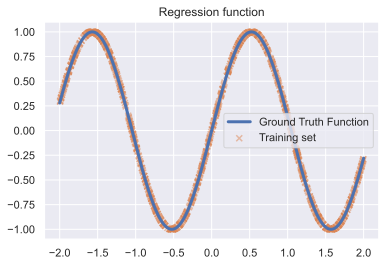

In [8]:
train_set = RegressionDataset(num_points=1000, seed=42)
val_set = RegressionDataset(num_points=200, seed=43)
test_set = RegressionDataset(num_points=500, seed=44)
train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=64)

x = np.linspace(-2, 2, 1000)
plt.scatter(train_set.x, train_set.y, color='C1', marker='x', alpha=0.5, label='Training set')
plt.plot(x, target_function(x), linewidth=3.0, label='Ground Truth Function')
plt.legend()
plt.title('Regression function')
plt.show()

Note that even with PyTorch Lightning, we would have needed the similar setup here.

### Model

The Trainer module does not restrict us to any specific model, so let's implement our own MLP class for regression:

In [9]:
class MLPRegressor(nn.Module):
    hidden_dims : Sequence[int]
    output_dim : int
        
    @nn.compact
    def __call__(self, x, **kwargs):
        for dims in self.hidden_dims:
            x = nn.Dense(dims)(x)
            x = nn.silu(x)
        x = nn.Dense(self.output_dim)(x)
        return x

### Trainer

Now comes the interesting part. Using the `TrainerModule`, we only need to overwrite the aspects that are needed: the training and validation step. For the regression task and the small model, this reduces to writing the mean-squared error loss. Note that we still have some minor repetitive code here, such as creating the gradient function with `jax.value_and_grad` in the training step and applying the update with `state.apply_gradients`. One could reduce this further by restricting possible loss functions, but to keep flexibility high, we implement the whole training step here.

In [10]:
class MLPRegressTrainer(TrainerModule):
    
    def __init__(self,
                 hidden_dims : Sequence[int],
                 output_dim : int,
                 **kwargs):
        super().__init__(model_class=MLPRegressor,
                         model_hparams={
                             'hidden_dims': hidden_dims,
                             'output_dim': output_dim
                         },
                         **kwargs)
    
    def create_functions(self):
        def mse_loss(params, batch):
            x, y = batch
            pred = self.model.apply({'params': params}, x)
            loss = ((pred - y) ** 2).mean()
            return loss
        
        def train_step(state, batch):
            loss_fn = lambda params: mse_loss(params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss = mse_loss(state.params, batch)
            return {'loss': loss}
        
        return train_step, eval_step

And that's already it! This now looks much more like the minimal code of PyTorch Lightning and automatically logs our metrics as we want.

### Training

To train the model, we simply specify our hyperparameters and create a Trainer module:

In [11]:
trainer = MLPRegressTrainer(hidden_dims=[128, 128],
                            output_dim=1,
                            optimizer_hparams={'lr': 4e-3},
                            logger_params={'base_log_dir': CHECKPOINT_PATH},
                            exmp_input=next(iter(train_loader))[0:1],
                            check_val_every_n_epoch=5)

                    MLPRegressor Summary                     
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path         ┃ outputs         ┃ params                   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs       │ - float64[64,1] │                          │
│              │ - train: True   │                          │
├──────────────┼─────────────────┼──────────────────────────┤
│ Dense_0      │ float32[64,128] │ bias: float32[128]       │
│              │                 │ kernel: float32[1,128]   │
│              │                 │                          │
│              │                 │ 256 (1.0 KB)             │
├──────────────┼─────────────────┼──────────────────────────┤
│ Dense_1      │ float32[64,128] │ bias: float32[128]       │
│              │                 │ kernel: float32[128,128] │
│              │                 │                          │
│              │                 │ 16,512 (66.0 KB)         │
├──────────────┼─────────────────┼──────────────────────────┤
│ Dense_2      │ float32[64,1]   │ bias: float32[1]         │
│              │                 │ kernel: float32[128,1]   │
│              │                 │                          │
│              │                 │ 129 (516 B)              │
├──────────────┼─────────────────┼──────────────────────────┤
│ MLPRegressor │ float32[64,1]   │                          │
├──────────────┼─────────────────┼──────────────────────────┤
│              │           Total │ 16,897 (67.6 KB)         │
└──────────────┴─────────────────┴──────────────────────────┘
                                                             
             Total Parameters: 16,897 (67.6 KB)              

As one can see, we also automatically print out all layers with their parameters and outputs with Flax's `nn.tabulate` function. This is quite helpful for debugging and gives an intuition about the size of the model. Since the task is not very difficult, we are fine with using less than 20k parameters.

Next, let's start the training:

In [12]:
metrics = trainer.train_model(train_loader, 
                              val_loader, 
                              test_loader=test_loader, 
                              num_epochs=50)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 0.0006527657969854772
Validation loss: 0.000675356830470264
Test loss: 0.0005879005184397101


With the speed of JAX, this takes only a few seconds. The logs can be found in `../saved_models/guide4/MLPRegressor/`, and we have a dictionary of the best results here as well. The training, validation and test loss suggest that our model learned the function quite well, but let's check it by predicting the whole function as inference task.

### Inference

To perform inference, we first bind the model to the parameters. This enables us a simpler API, closer to PyTorch. Applying the model to a values between -2.0 and 2.0 shows that the model learned the sine wave indeed quite well and is only off at the corners.

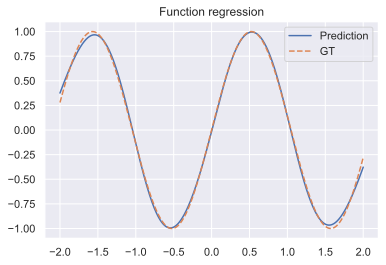

In [14]:
model_bd = trainer.bind_model()
x = np.linspace(-2, 2, 1000)[:,None]
y_pred = model_bd(x)
plt.plot(x, y_pred, label='Prediction')
plt.plot(x, target_function(x), '--', label='GT')
plt.title('Function regression')
plt.legend()
plt.show()

## Example 2: CIFAR10 classification

As a second example, let's consider image classification on CIFAR10. We have done it before in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html), but here, we want to showcase the flexibility of the Trainer module. For that, we will consider a more complicated setting in Flax: a model with both Batch Normalization and Dropout. However, with the Trainer module, this reduces to a simpler code again.

### Dataset

First, let's load our dataset again. This is the same data loading as used in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html) and [Tutorial 15](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial15/Vision_Transformer.html), but only considers flipping as regularization technique since we work with simple MLPs here.

In [14]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img


test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      image_to_numpy])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=256)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Model

The model definition is again relatively simple. We repeat a series of Dropout $\to$ Linear $\to$ BatchNorm $\to$ Swish blocks, with a final Dropout and Linear layer at the end.

In [15]:
class MLPClassifier(nn.Module):
    hidden_dims : Sequence[int]
    num_classes : int
    dropout_prob : float = 0.0
        
    @nn.compact
    def __call__(self, x, train=True):
        x = x.reshape(x.shape[0], -1)
        for dims in self.hidden_dims:
            x = nn.Dropout(self.dropout_prob)(x, deterministic=not train)
            x = nn.Dense(dims)(x)
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = nn.swish(x)
        x = nn.Dropout(self.dropout_prob)(x, deterministic=not train)
        x = nn.Dense(self.num_classes)(x)
        return x

### Trainer

For the Trainer module, we again define our model hyperparameters in the init function, and write our own training and evaluation steps in `create_functions`. In these functions, we take care of the mutable batch statistics and the PRNG state for dropout. Note that since both parts are integrated in the `TrainState`, we do not need to alternate the training or validation step signature, and it is sufficient to pass the state and batch to the functions. Additionally, we overwrite the model call during initialization (`run_model_init`) and tabulate function (`print_tabulate`). And that's it! Overall, we didn't need to make many changes, showing that the trainer module is flexible enough to support a variety of layers. For now, we can ignore the `trial` object and come back to it later when discussing automated hyperparameter tuning.

In [16]:
class MLPClassTrainer(TrainerModule):
    
    def __init__(self,
                 hidden_dims : Sequence[int],
                 num_classes : int,
                 dropout_prob : float,
                 trial : Any = None,
                 **kwargs):
        super().__init__(model_class=MLPClassifier,
                         model_hparams={
                             'hidden_dims': hidden_dims,
                             'num_classes': num_classes,
                             'dropout_prob': dropout_prob
                         },
                         **kwargs)
        self.trial = trial
    
    def create_functions(self):
        def loss_function(params, batch_stats, rng, batch, train):
            imgs, labels = batch
            labels_onehot = jax.nn.one_hot(labels, num_classes=self.model.num_classes)
            rng, dropout_rng = random.split(rng)
            output = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                      imgs,
                                      train=train,
                                      rngs={'dropout': dropout_rng},
                                      mutable=['batch_stats'] if train else False)
            logits, new_model_state = output if train else (output, None)
            loss = optax.softmax_cross_entropy(logits, labels_onehot).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (rng, new_model_state, acc)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_function(params, state.batch_stats, state.rng, batch, train=True)
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, rng, new_model_state, acc = ret[0], *ret[1]
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'], rng=rng)
            metrics = {'loss': loss, 'acc': acc}
            return state, metrics
        
        def eval_step(state, batch):
            _, (_, _, acc) = loss_function(state.params, state.batch_stats, state.rng, batch, train=False)
            return {'acc': acc}
        
        return train_step, eval_step
    
    def run_model_init(self, exmp_input, init_rng):
        imgs, _ = exmp_input
        init_rng, dropout_rng = random.split(init_rng)
        return self.model.init({'params': init_rng, 'dropout': dropout_rng}, x=imgs, train=True)
    
    def print_tabulate(self, exmp_input):
        imgs, _ = exmp_input
        print(self.model.tabulate(rngs={'params': random.PRNGKey(0), 'dropout': random.PRNGKey(0)}, x=imgs, train=True))
        
    def on_validation_epoch_end(self, epoch_idx, eval_metrics, val_loader):
        if self.trial:
            self.trial.report(eval_metrics['val/acc'], step=epoch_idx)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()

### Training

With the Trainer fully defined, we can again start training. Let's pick some reasonable hyperparameters, and look at the layers created by the model:

In [17]:
trainer = MLPClassTrainer(hidden_dims=[512, 512],
                          num_classes=10,
                          dropout_prob=0.4,
                          optimizer_hparams={
                              'weight_decay': 2e-4,
                              'lr': 1e-3
                          },
                          logger_params={
                              'base_log_dir': CHECKPOINT_PATH
                          },
                          exmp_input=next(iter(train_loader)),
                          check_val_every_n_epoch=5)

                                   MLPClassifier Summary                                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path          ┃ outputs                 ┃ batch_stats        ┃ params                    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs        │ train: True             │                    │                           │
│               │ x: float64[256,32,32,3] │                    │                           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ BatchNorm_0   │ float32[256,512]        │ mean: float32[512] │ bias: float32[512]        │
│               │                         │ var: float32[512]  │ scale: float32[512]       │
│               │                         │                    │                           │
│               │                         │ 1,024 (4.1 KB)     │ 1,024 (4.1 KB)            │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ BatchNorm_1   │ float32[256,512]        │ mean: float32[512] │ bias: float32[512]        │
│               │                         │ var: float32[512]  │ scale: float32[512]       │
│               │                         │                    │                           │
│               │                         │ 1,024 (4.1 KB)     │ 1,024 (4.1 KB)            │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dense_0       │ float32[256,512]        │                    │ bias: float32[512]        │
│               │                         │                    │ kernel: float32[3072,512] │
│               │                         │                    │                           │
│               │                         │                    │ 1,573,376 (6.3 MB)        │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dense_1       │ float32[256,512]        │                    │ bias: float32[512]        │
│               │                         │                    │ kernel: float32[512,512]  │
│               │                         │                    │                           │
│               │                         │                    │ 262,656 (1.1 MB)          │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dense_2       │ float32[256,10]         │                    │ bias: float32[10]         │
│               │                         │                    │ kernel: float32[512,10]   │
│               │                         │                    │                           │
│               │                         │                    │ 5,130 (20.5 KB)           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dropout_0     │ float32[256,3072]       │                    │                           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dropout_1     │ float32[256,512]        │                    │                           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ Dropout_2     │ float32[256,512]        │                    │                           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│ MLPClassifier │ float32[256,10]         │                    │                           │
├───────────────┼─────────────────────────┼────────────────────┼───────────────────────────┤
│               │                   Total │ 2,048 (8.2 KB)     │ 1,843,210 (7.4 MB)        │
└───────────────┴─────────────────────────┴────────────────────┴───────────────────────────┘
                                                                                            
 

Process Process-91:
Process Process-89:
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/home/phillip/anaconda3/envs/dl2020/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/phillip/anaconda3/envs/dl2020/lib/pytho

One interesting observation here is that the MLP has way more parameters than any of the CNNs in [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial5/Inception_ResNet_DenseNet.html), but yet significantly underperforms the models. Although to really see the performance, let's train the model again with the simple call from before:

In [18]:
metrics = trainer.train_model(train_loader, 
                              val_loader, 
                              test_loader=test_loader, 
                              num_epochs=50)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

Training:   0%|          | 0/175 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(f'Validation accuracy: {metrics["val/acc"]:4.2%}')
print(f'Test accuracy: {metrics["test/acc"]:4.2%}')

The MLP achieves decent accuracy, but already for models like this, we have several hyperparameters to tune including learning rate, weight decay, dropout rate. Which should we choose? While we could use intuition to get a reasonable guess, it is unlikely that we hit the best hyperparameter set. In order to find a very strong hyperparameter set, a good practice is to use automatic hyperparameter tuning, which we shortly review next to showcase the flexibility of the Trainer module.

## Automatic hyperparameter tuning with Optuna

Automatic hyperparameter tuner have the goal to efficiently identify sets of hyperparameters that achieve the best performance. Thereby, the key question is how can we search the hyperparameter space efficiently, since we don't have infinite compute. [Optuna](https://optuna.readthedocs.io/en/stable/) is a library that helps you setup this search with minimal code overhead and perform automatic hyperparameter tuning. Before getting started with Optuna, let's import the library and download a pre-executed hyperparameter search as an example.

In [ ]:
try:
    import optuna
except ModuleNotFoundError:
    !pip install --quiet --upgrade optuna pyplot
    import optuna

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/guide4/"
# Files to download
pretrained_files = ["optuna_hparam_search.db", "MLPClassifier/checkpoint_150", "MLPClassifier/hparams.json"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

### Defining objective and hyperparameters

The main part a user has to specify in Optuna is intuitively the the objective to optimize, and the hyperparameters over which we want to optimize. In our case, the objective is to optimize the validation accuracy of the MLP. Note that we do not use the test set here, since hyperparameter searches should only be done on the validation set, not the "unseen" test set! The function below, `objective(trial)`, creates a MLP with our trainer module and trains it for max. 200 epochs. The input argument, `trial`, is thereby an object which characterizes the current run. This includes, for example, the hyperparameters we want to optimize. In order to add a hyperparameter to our optimization set, we can simply call `trial.suggest_float` for continuous values and `trial.suggest_categorical` for categorical values (e.g. which optimizer to use). For the CIFAR10 classification, we consider the following three hyperparameters: dropout rate, weight decay, and the learning rate, which we define below. Finally, we return the best validation accuracy which will be used by Optuna to guide the next pick of hyperparameters.

In [ ]:
def objective(trial):
    my_train_loader, my_val_loader = create_data_loaders(train_set, val_set,
                                                         train=[True, False],
                                                         batch_size=256)
    trainer = MLPClassTrainer(hidden_dims=[512, 512],
                              num_classes=10,
                              dropout_prob=trial.suggest_float('dropout_prob', 0, 0.6),
                              optimizer_hparams={
                                  'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
                                  'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
                              },
                              logger_params={
                                  'base_log_dir': CHECKPOINT_PATH
                              },
                              exmp_input=next(iter(my_train_loader)),
                              check_val_every_n_epoch=5,
                              trial=trial)
    metrics = trainer.train_model(my_train_loader,
                                  my_val_loader,
                                  num_epochs=200)
    del trainer
    del my_train_loader, my_val_loader
    return metrics['val/acc']

### Running hyperparameter study

To run the hyperparameter search, we create a `Study` in Optuna. A study implements the search logic and summarizes the data/logs of all executed experiments. By default, Optuna uses the [Tree-Structured Parzen Estimator](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler) algorithm, using Gaussian Mixture Models to estimate the performance surface of they hyperparameters. For more information, check out the [documentation](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler). The studies are usually stored in a database format, but can be easily accessed via the Python interface of Optuna. Let's run the hyperparameter search for up to 25 models:

In [ ]:
study = optuna.create_study(
    study_name='mlp_cifar10',
    storage=f'sqlite:///{CHECKPOINT_PATH}/optuna_hparam_search.db',
    direction='maximize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    load_if_exists=True
)
study.optimize(objective, n_trials=25-len(study.trials), n_jobs=1)

During the study creation, we used the input argument `pruner`. This specifies a strategy with which we want to stop experiments early if they don't look promising. For instance, a very low learning rate combined with high weight decay and dropout will likely achieve low performance, which we can already judge after 50 epochs and don't have to run the model for much longer. For this, we implemented the `on_validation_epoch_end` callback in our Trainer module before. After each epoch, it reports the current validation performance to Optuna. Depending on the previous performances and Optuna's pruning strategy, it may decide to stop the experiment early, which it does by throwing a `TrialPruned` error. This error is caught by Optuna, and the next trial is directly started.

### Evaluate hyperparameter search

After finishing the hyperparameter search, we can analyze the results. First, let's print the best model found and its corresponding hyperparameters:

In [ ]:
trial = study.best_trial
print(f'Best Validation Accuracy: {trial.value:4.2%}')
print(f'Best Params:')
for key, value in trial.params.items():
    print(f'-> {key}: {value}')

The validation performance is quite a bit higher than the model we had manually designed before. Let's load the model and check its test performance. For this, we can make use of the `load_from_checkpoint` function of our Trainer module:

In [ ]:
trainer = MLPClassTrainer.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, 'MLPClassifier/version_16/'), 
                                               exmp_input=next(iter(train_loader)))
test_metrics = trainer.eval_model(test_loader)
print(f'Test accuracy: {test_metrics["acc"]:4.2%}')

The test performance is also quite strong, showing the benefit of the automatic hyperparameter search. However, often, we are not just interested in the best model. Optuna provides several ways of visualizing the results of the hyperparameter study, for instance by plotting all validation accuracy curves:

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

As we can see, there is quite a big group of models that perform very similarly. At the same time, there were a few models with very poor results, which were lucky stopped early by Optuna to not waste compute. 

Another question we might have is which hyperparameter was the most important for the performance? This can be directly visualized by `plot_param_importances`. By default, Optuna uses a random forest regression to estimate the importance of each hyperparameter ([documentation](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html#optuna.importance.FanovaImportanceEvaluator)), and shows it as values that sum up to 1 for all hyperparameters:

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

Interestingly, the learning rate is the most important hyperparameter. 

Finally, to get a good intuition of the interplay between hyperparameters, we can plot the estimated accuracy surface over hyperparameters:

In [ ]:
fig = optuna.visualization.plot_contour(study, params=['lr', 'dropout_prob'])
fig.show()

As the hyperparameter importance plot already suggested, the learning rate seems to be very important while we are more flexible in the dropout probability. However, there seems to be an optimal spot in the middle, overall maximizing the accuracy.

## Conclusion

In this guide, we discussed tips and practices for doing research with JAX. We mainly focused on implementing a Trainer module that summarizes most common functionalities needed for training and testing models. To showcase the flexibility of the module, we implement a regression and classification model in a few lines. Moreover, we show how one can easily perform automatic hyperparameter optimization with Optuna in this setting. While this guide gives a possible template for a research code, it may not cover all parts that is needed for your specific usecase. Moreover, if you are specialized on a certain task, such as classification or generative models, you can further specialize the Trainer module to reduce your code for submodules.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---